In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# import plt
import matplotlib.pyplot as plt

from ray import train, tune
from ray.train import Checkpoint, session, report
from ray.tune.schedulers import ASHAScheduler

import os
import tempfile


/home/luigi/anaconda3/envs/ray/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/luigi/anaconda3/envs/ray/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Set the directory containing the images
input_directory = "data"

# add to grey
transform = transforms.Compose([transforms.Resize(100),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor()])

dataset = datasets.ImageFolder(input_directory, transform=transform)

# Get the class labels and split the dataset into train and test sets
class_labels = dataset.classes
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, random_state=42)

# Print the number of samples in each split
print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))



# Create data loaders
batch_size = 24 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train set size: 192
Test set size: 64


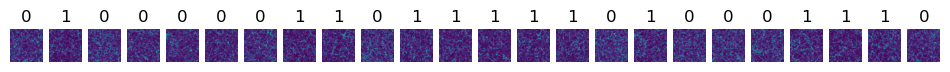

In [3]:
# show the images from the first batch with their labels
for images, labels in train_loader:
    # big figure
    fig, ax = plt.subplots(1, len(images), figsize=(12, 12))
    for i, image in enumerate(images):
        ax[i].imshow(image[0])
        ax[i].set_title(labels[i].item())
        ax[i].axis('off')
    break

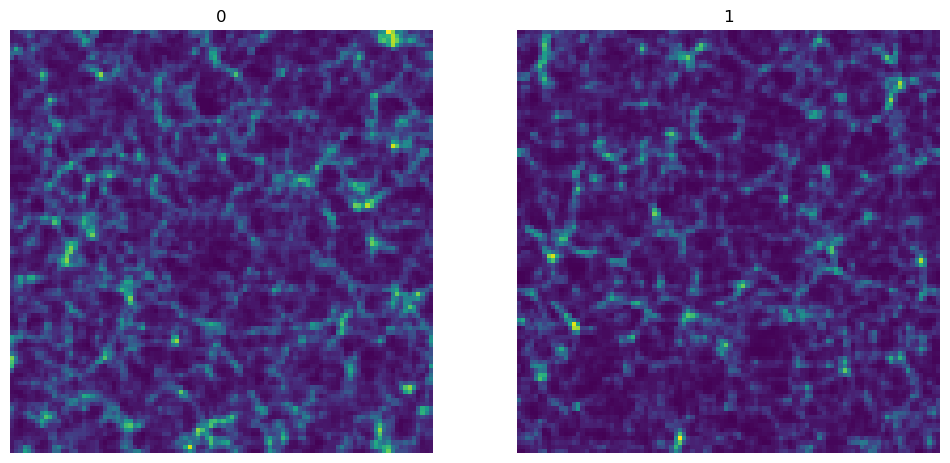

In [4]:
# show jyst two images
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[0][0])
ax[0].set_title(labels[0].item())
ax[0].axis('off')
ax[1].imshow(images[1][0])
ax[1].set_title(labels[1].item())
ax[1].axis('off')
plt.show()

In [5]:
# get dimension
print(images[0].shape)

torch.Size([1, 100, 100])


In [6]:
# define the model
# this is a VAE model
# for the encoder, two Conv2d layers are used to extract features from the input image
# the output image is of size 1x100x100
# first have 32 filters and kernel size 4, stride 2, padding 1
# second have 64 filters and kernel size 4, stride 2, padding 1
# then the output is flattened 
# the latent space is represented by two vectors, mean and logvar, dimension 2

# for the decoder, the latent space is first passed through a linear layer to get a tensor of size 64
# then reshaped to a tensor of size 64x1x1
# then passed through two ConvTranspose2d layers to get the output image
# first have 64 filters and kernel size 4, stride 2, padding 1
# second have 32 filters and kernel size 4, stride 2, padding 1
# the output image is of size 1x100x100

class VAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        self.fc1 = torch.nn.Linear(64*25*25, latent_dim)
        self.fc2 = torch.nn.Linear(64*25*25, latent_dim)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64*25*25),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (64, 25, 25)),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [7]:
# define the model
latent_dim = 2
model = VAE(latent_dim)

# define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [8]:
# test the model
reconst, mu, logvar = model(images)

In [9]:
# train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {train_loss/len(train_loader.dataset)}')

Epoch 0, Loss 4882.200520833333
Epoch 1, Loss 3768.6260986328125
Epoch 2, Loss 3635.644490559896
Epoch 3, Loss 3588.958984375
Epoch 4, Loss 3560.7806803385415
Epoch 5, Loss 3541.65234375
Epoch 6, Loss 3529.4385579427085
Epoch 7, Loss 3515.2962646484375
Epoch 8, Loss 3508.4734700520835
Epoch 9, Loss 3500.999552408854
Epoch 10, Loss 3494.545939127604
Epoch 11, Loss 3489.055948893229
Epoch 12, Loss 3484.076171875
Epoch 13, Loss 3479.8843994140625
Epoch 14, Loss 3476.575154622396
Epoch 15, Loss 3473.217569986979
Epoch 16, Loss 3470.9409993489585
Epoch 17, Loss 3468.6802978515625
Epoch 18, Loss 3466.8761393229165
Epoch 19, Loss 3465.197062174479
Epoch 20, Loss 3463.9200439453125
Epoch 21, Loss 3463.244099934896
Epoch 22, Loss 3461.8507486979165
Epoch 23, Loss 3460.7915852864585
Epoch 24, Loss 3459.844523111979
Epoch 25, Loss 3458.750691731771
Epoch 26, Loss 3458.2849934895835
Epoch 27, Loss 3457.8463134765625
Epoch 28, Loss 3457.3052571614585
Epoch 29, Loss 3457.721964518229
Epoch 30, Loss 

In [10]:
path = os.getcwd()
results_dir = os.path.join(path, "tune")
os.makedirs(results_dir, exist_ok=True)

In [11]:
# define the objective for ray tune
def objective(config):
    # define the model
    model = VAE(config["latent_dim"])

    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters())

    # define the loss function
    def loss_function(recon_x, x, mu, logvar):
        BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    # load the data
    batch_size = 24 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # train the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, (images, _) in enumerate(train_loader):
            optimizer.zero_grad()
            recon_images, mu, logvar = model(images)
            loss = loss_function(recon_images, images, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()  

        # get the objective loss 
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (images, _) in enumerate(test_loader):
                recon_images, mu, logvar = model(images)
                test_loss += loss_function(recon_images, images, mu, logvar).item()
        
        report(metrics={"loss": test_loss})
    
    return train_loss

In [12]:
# configuration space and sampling method
config = {
    "latent_dim": tune.randint(2, 10)
}



# schedueler ASHA
scheduler = ASHAScheduler(
    metric="loss", 
    mode="min", 
    max_t=100,
    grace_period=10, 
    reduction_factor=2
    )


tuner = tune.Tuner(
    objective,
    param_space=config,
    tune_config=tune.TuneConfig(
        num_samples=5,
        scheduler=scheduler,
    ),
    run_config=train.RunConfig(
        name="Slices_tuning",
        storage_path=results_dir
    )
)

In [13]:
results = tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (19 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(objective pid=8975) Epoch 0, Loss 4865.368733723958
(objective pid=8974) Epoch 1, Loss 3754.0191650390625 [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(objective pid=8976) Epoch 3, Loss 3593.101847330729 [repeated 9x across cluster]
(objective pid=8973) Epoch 5, Loss 3522.447550455729 [repeated 9x across cluster]
(objective pid=8975) Epoch 7, Loss 3508.156697591146 [repeated 9x across cluster]
(objective pid=8980) Epoch 9, Loss 3508.925496419271 [repeated 8x across cluster]
(objective pid=8976) Epoch 10, Loss 3491.8528645833335 [repeated 9x across cluster]
(objective pid=8980) Epoch 13, Lo

2024-05-22 13:55:53,260	INFO tune.py:1042 -- Total run time: 211.18 seconds (211.06 seconds for the tuning loop).


In [15]:

df = results.get_dataframe()
df


,loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/latent_dim,logdir
0,218360.769531,1716378953,None,True,100,bfc58_00000,2024-05-22_13-55-53,1.740635,205.040157,8973,luigi-tifpa,193.157.171.213,205.040157,100,3,bfc58_00000
1,220044.960938,1716378851,None,True,40,bfc58_00001,2024-05-22_13-54-11,2.162875,104.453744,8974,luigi-tifpa,193.157.171.213,104.453744,40,4,bfc58_00001
2,221062.765625,1716378810,None,True,20,bfc58_00002,2024-05-22_13-53-30,3.322727,63.740155,8975,luigi-tifpa,193.157.171.213,63.740155,20,6,bfc58_00002
3,220875.718750,1716378809,None,True,20,bfc58_00003,2024-05-22_13-53-29,2.601640,62.255125,8976,luigi-tifpa,193.157.171.213,62.255125,20,6,bfc58_00003
4,218899.765625,1716378951,None,True,100,bfc58_00004,2024-05-22_13-55-51,1.868509,203.843451,8980,luigi-tifpa,193.157.171.213,203.843451,100,4,bfc58_00004


In [16]:
def get_alive_model(df, max_epoch):
    """
    Function to get the number of alive models at each epoch
    input: df, max_epoch
    output: alive_model
    """
    # get traininig_iteration vector
    training_iteration = df["training_iteration"]
    training_iteration = training_iteration.to_numpy()
    # alive_model = number of entries of training_iteration > epoch
    # epoch = (0, max_epoch)
    alive_model = np.zeros(max_epoch)
    for i in range(max_epoch):
        alive_model[i] = np.sum(training_iteration > i)
    return alive_model

alive_model = get_alive_model(df, 100)

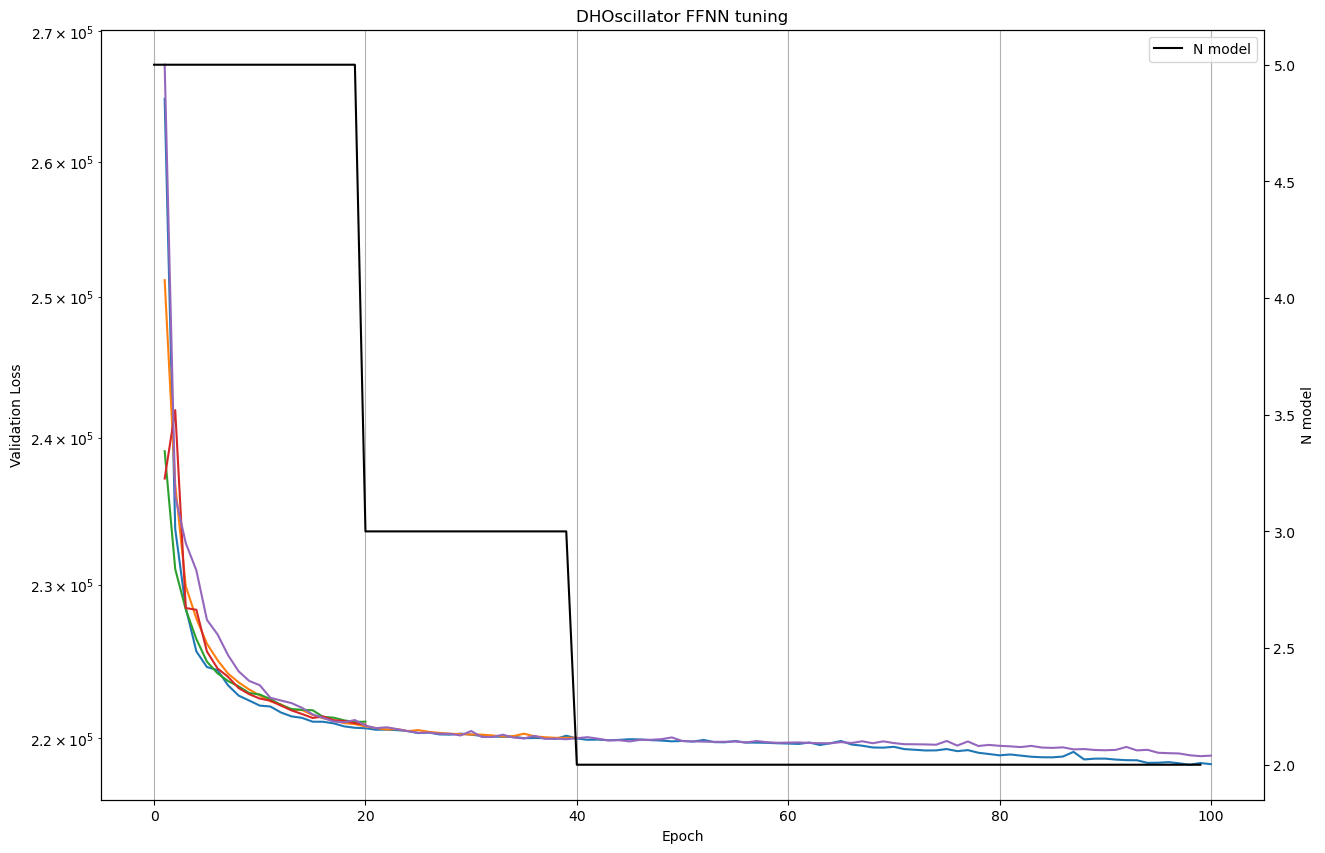

In [18]:
# show results
dfs = {result.path: result.metrics_dataframe for result in results}

# twinx plot alive_model and validation loss
fig, ax1 = plt.subplots(figsize=(15, 10))
# plot the validation loss
for path, df in dfs.items():
    ax1.plot(df["training_iteration"], df["loss"], label=path)
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.grid()

# plot the alive model
ax2 = ax1.twinx()
ax2.plot(alive_model, label="N model", color="black")
ax2.set_ylabel("N model")
ax2.legend()
ax2.grid()


plt.title("DHOscillator FFNN tuning")
plt.grid()

# save the plot